In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

#X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
#Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

X_motion = X_footsteps_accelerations_absolute
Y_motion = Y_footsteps_accelerations_absolute

print(X_motion.shape)
print(Y_motion.shape)

(1932, 20)
(1932, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging.shape

(963, 20)

In [9]:
Y_motion_FL_swinging.shape

(963, 4)

In [10]:
X_motion_FL_swinging[0:10, 0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

### Linear Regression

In [11]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, -5:-2], # Current motion command
               X_motion_FL_swinging[:, 3:5], # FL (x,y) position
               X_motion_FL_swinging[:, 6:8], # FR (x,y) position
               X_motion_FL_swinging[:, 9:11], # RL (x,y) position
               X_motion_FL_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9966668986062202
RMSE:  0.0071998807634947905
The lowest error is:  7.858639046565141e-05
The highest error is:  0.028364580945965945
The avg. error is:  0.0054244283649872915


In [12]:
model_fl_relative_support_x.coef_

array([[ 2.75128539e-01,  5.55111512e-17, -2.22044605e-16,
        -4.90190824e-02, -8.32667268e-17, -2.22044605e-16,
        -9.77484332e-01, -6.74978202e-02,  5.39225677e-01,
         2.85760039e-01,  7.26984017e-01,  4.74330926e-02,
        -2.64292811e-01, -2.17202346e-01]])

In [13]:
model_fl_relative_support_x.intercept_

array([0.23595124])

Text(0, 0.5, 'Predictions')

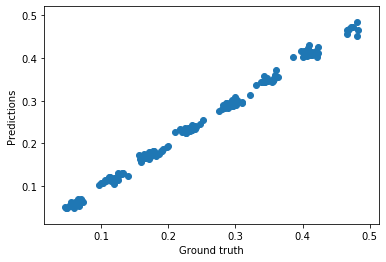

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, -5:-2], # Current motion command
               X_motion_FL_swinging[:, 3:5], # FL (x,y) position
               X_motion_FL_swinging[:, 6:8], # FR (x,y) position
               X_motion_FL_swinging[:, 9:11], # RL (x,y) position
               X_motion_FL_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -1.260843661136696
RMSE:  0.004655252603773819
The lowest error is:  2.0297721794602236e-05
The highest error is:  0.014657783802817435
The avg. error is:  0.0036397219296939558


In [17]:
model_fl_relative_support_y.coef_

array([[-4.69329271e-03,  1.48752538e-16,  3.46944695e-17,
        -3.12448784e-02, -6.93889390e-17, -5.55111512e-17,
         9.93743494e-02, -8.24554160e-01,  1.16979790e-01,
         2.88328439e-01, -1.64376979e-03,  7.86025764e-02,
        -2.16598531e-01, -2.25832176e-01]])

In [18]:
model_fl_relative_support_y.intercept_

array([-0.00487445])

Text(0, 0.5, 'Predictions')

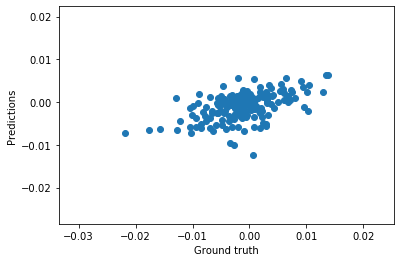

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')